Необходимо сделать:
1.	Собрать из предложенных файлов датасет.
2.	Провести EDA, отобрать фичи и сгенерировать новые.
3.	Обучить модель.
4.	Собрать исполняемый код, который можно будет запустить на проде: на вход будет получать файлы аналогичного формата (по одному), возвращать должен прогнозное значение.


<a name="1common."></a>
## <a name="0.0"></a>Содержание:

 - [1. Погружаем данные. перчичный анализ](#1)
 - [2. Парсим www.spark-interfax.ru](#2)
 - [3. Финализируем выборку.Тестим модели](#3)
 - [4. Выводы](#4)

<a name="1.1"></a><br/>
<font size="3"><b>1.1 Погружаем данные. перчичный анализ</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import time
from datetime import datetime

# импорт библиотеки pandas
import pandas as pd 
from pandas import DataFrame
import numpy as np

# чтобы открыть спарсенную инфу из json
import pickle
import glob

# библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns

#для парсинга
import requests as requests
from fake_useragent import UserAgent

# ML
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# модели
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
start1 = time.time()

In [2]:
link_to_source = '/home/catfox/Downloads/Sample Task/court_cases_sample/success/'

In [3]:
list_of_files_court_cases_sample = glob.glob(link_to_source + "/*.*")
display('Кол-во josn:',len(list_of_files_court_cases_sample))
list_of_files_court_cases_sample[-5:]

'Кол-во josn:'

193

['/home/catfox/Downloads/Sample Task/court_cases_sample/success/5044075933.pkl',
 '/home/catfox/Downloads/Sample Task/court_cases_sample/success/1411004211_b.pkl',
 '/home/catfox/Downloads/Sample Task/court_cases_sample/success/3436108015_b.pkl',
 '/home/catfox/Downloads/Sample Task/court_cases_sample/success/2907015620.pkl',
 '/home/catfox/Downloads/Sample Task/court_cases_sample/success/3212001450_b.pkl']

In [4]:
with open(list_of_files_court_cases_sample[0], 'rb') as f:
    data = pickle.load(f)
data

{'inn': 2312011001,
 'cases_list': [{'caseNo': 'А32-10458/1999',
   'resultType': 'Не удалось определить',
   'caseDate': '2018-11-28T00:00:00',
   'caseType': {'code': '90', 'name': 'не определено'},
   'sum': 0.0,
   'currency': 643,
   'isActive': False,
   'currentInstance': '15 арбитражный апелляционный суд',
   'instanceDate': '2019-02-06T00:00:00',
   'documents': [{'document_name': 'Прекратить производство по апелляционной жалобе (ст.265, по аналогии со ст.150 АПК)',
     'document_date': '2019-02-06T00:00:00',
     'document': 'http://kad.arbitr.ru/kad/pdfdocument/dc381540-7aaa-4069-b9d9-b401c0339377/A32-10458-1999_20190206_Opredelenie.pdf',
     'judge_name': 'Илюшин Р. Р., Нарышкина Н. В., Фахретдинов Т. Р.',
     'court_name': '15 арбитражный апелляционный суд'},
    {'document_name': 'Прекратить производство по апелляционной жалобе (ст.265, по аналогии со ст.150 АПК)',
     'document_date': '2019-02-05T00:00:00',
     'document': 'http://kad.arbitr.ru/kad/pdfdocument/b81d8

In [5]:
data['cases_list'][0]['case_sides'][3]

{'name': 'Сухомлинов Сергей Александрович', 'type': 3, 'OGRN': None, 'INN': ''}

In [6]:
list_of_files_court_cases_sample[0]

'/home/catfox/Downloads/Sample Task/court_cases_sample/success/2312011001.pkl'

In [7]:
data.keys()

dict_keys(['inn', 'cases_list', 'error', 'n_requests'])

In [8]:
data['error']

In [9]:
data['n_requests']

1

    Видим жирный json. Основная инфа храниться в ключе cases_list.
    Чтобы было наглядно, распарсим в таблу, чтобы потом удобно было брать фичи.
    Смотрим на структуру и собираем.

In [10]:
%%time
# запустим проверку одинаково ли количество ключей в файлах.
counter_keys = []

counter_of_keys_cases_list = []

counter_of_keys_cases_sides_list = []

for json in list_of_files_court_cases_sample:
    
    with open(json, 'rb') as f:        
        data = pickle.load(f)
        
        if len(data.keys()) not in counter_keys:            
            counter_keys.append(len(data.keys()))
            
        for num_case in range(len(data['cases_list'])):
            
            if len(data['cases_list'][num_case].keys()) not in counter_of_keys_cases_list:                
                counter_of_keys_cases_list.append(len(data['cases_list'][num_case].keys()))
                
            if len(data['cases_list'][num_case]['case_sides']) not in counter_of_keys_cases_sides_list:
                counter_of_keys_cases_sides_list.append(len(data['cases_list'][num_case]['case_sides']))
            
display(counter_keys)
display(counter_of_keys_cases_sides_list)
counter_of_keys_cases_list

[4]

[5,
 2,
 13,
 6,
 4,
 3,
 20,
 7,
 53,
 8,
 80,
 106,
 15,
 29,
 11,
 10,
 12,
 17,
 97,
 70,
 89,
 166,
 119,
 238,
 118,
 147,
 71,
 472,
 72,
 98,
 9,
 14,
 50,
 49,
 19,
 163,
 90,
 26,
 23,
 87,
 40,
 84,
 66,
 32,
 54,
 48,
 25,
 16,
 127,
 42,
 51,
 46,
 38,
 69,
 31,
 22,
 37,
 79,
 24,
 221,
 1,
 35,
 209,
 92,
 239,
 21,
 319,
 33,
 61,
 27,
 28,
 30,
 52,
 122,
 77,
 134,
 146,
 431,
 296,
 41,
 58,
 498,
 43,
 65,
 45,
 176,
 59,
 36,
 94,
 214,
 18,
 111,
 82,
 74,
 150,
 34,
 145,
 78,
 640,
 115,
 236,
 123,
 195,
 44,
 103,
 47,
 62,
 140,
 68,
 187,
 199,
 205,
 63,
 64,
 75,
 149,
 93,
 55,
 39,
 57,
 110,
 170,
 0,
 86,
 104,
 99,
 477,
 161,
 137,
 169,
 56,
 108,
 114,
 73,
 60,
 232,
 76,
 142,
 198,
 405,
 213,
 185,
 717,
 175,
 148]

CPU times: user 470 ms, sys: 119 ms, total: 589 ms
Wall time: 706 ms


[11]

In [11]:
data['cases_list'][1].keys()

dict_keys(['caseNo', 'resultType', 'caseDate', 'caseType', 'sum', 'currency', 'isActive', 'currentInstance', 'instanceDate', 'documents', 'case_sides'])

In [12]:
data['cases_list'][num_case]['documents']

[{'document_name': 'Удовлетворить иск полностью или частично',
  'document_date': '2009-02-09T00:00:00',
  'document': 'http://kad.arbitr.ru/kad/pdfdocument/3555de0a-f204-4ff9-ada4-8731d1798c67/A09-7266-2008_20090209_Reshenie.pdf',
  'judge_name': 'Кожанов А. А.',
  'court_name': 'АС Брянской области'},
 {'document_name': 'Отложить судебное разбирательство (ст.157, 158 АПК)',
  'document_date': '2009-01-20T00:00:00',
  'document': 'http://kad.arbitr.ru/kad/pdfdocument/cead6d9c-755a-45be-9977-1b80e97b7969/A09-7266-2008_20090120_Opredelenie.pdf',
  'judge_name': 'Кожанов А. А.',
  'court_name': 'АС Брянской области'},
 {'document_name': 'Назначить дело к судебному разбирательству (ст.137 АПК)',
  'document_date': '2008-12-15T00:00:00',
  'document': 'http://kad.arbitr.ru/kad/pdfdocument/01cc0bb1-de45-4760-aa83-4740e5a48186/A09-7266-2008_20081215_Opredelenie.pdf',
  'judge_name': 'Кожанов А. А.',
  'court_name': 'АС Брянской области'},
 {'document_name': 'Назначить предварительное судебно

In [13]:
data['cases_list'][0].keys()

dict_keys(['caseNo', 'resultType', 'caseDate', 'caseType', 'sum', 'currency', 'isActive', 'currentInstance', 'instanceDate', 'documents', 'case_sides'])

In [14]:
data['cases_list'][num_case].keys()

dict_keys(['caseNo', 'resultType', 'caseDate', 'caseType', 'sum', 'currency', 'isActive', 'currentInstance', 'instanceDate', 'documents', 'case_sides'])

In [15]:
%%time
'''
Алгоритм:
берем каждый файл '/home/catfox/Downloads/Sample Task/court_cases_sample/success/2312011001.pkl'
затем смотрим на ключи dict_keys(['inn', 'cases_list', 'error', 'n_requests'])
из каждого ключа вытаскиваем инфу записываем в таблу
'''
# табла куда пишем сборку
df_files_court_cases_sample = pd.DataFrame()

# цикл сборки
for json in list_of_files_court_cases_sample:
    with open(json, 'rb') as f:
        data = pickle.load(f)
        
        # временная табла
        temp_table1 = pd.DataFrame()
        for num_case in range(len(data['cases_list'])):
            temp_table = pd.DataFrame()
            for key in data['cases_list'][num_case].keys():

                temp_table.loc[num_case, key] = str(data['cases_list'][num_case][key])
            # записываем результат по каждому делу во временную таблу
            temp_table1 = temp_table1.append(temp_table)

        for main_key in ['inn', 'error', 'n_requests']:
            temp_table1[main_key] = data[main_key]
        temp_table1['file_name'] = json.replace(link_to_source, '')
        # записываем результат по всем делам организации таблу сборки
        df_files_court_cases_sample = df_files_court_cases_sample.append(temp_table1)
        
        
# сбросим индексы        
df_files_court_cases_sample = df_files_court_cases_sample.reset_index(drop = True)

CPU times: user 1min 41s, sys: 440 ms, total: 1min 42s
Wall time: 1min 42s


In [16]:
df_files_court_cases_sample.head(1)

,caseNo,resultType,caseDate,caseType,sum,currency,isActive,currentInstance,instanceDate,documents,case_sides,inn,error,n_requests,file_name
0,А32-10458/1999,Не удалось определить,2018-11-28T00:00:00,"{'code': '90', 'name': 'не определено'}",0.0,643,False,15 арбитражный апелляционный суд,2019-02-06T00:00:00,"[{'document_name': 'Прекратить производство по апелляционной жалобе (ст.265, по аналогии со ст.150 АПК)', 'document_date': '2019-02-06T00:00:00', 'document': 'http://kad.arbitr.ru/kad/pdfdocument/dc381540-7aaa-4069-b9d9-b401c0339377/A32-10458-1999_20190206_Opredelenie.pdf', 'judge_name': 'Илюшин Р. Р., Нарышкина Н. В., Фахретдинов Т. Р.', 'court_name': '15 арбитражный апелляционный суд'}, {'document_name': 'Прекратить производство по апелляционной жалобе (ст.265, по аналогии со ст.150 АПК)', 'document_date': '2019-02-05T00:00:00', 'document': 'http://kad.arbitr.ru/kad/pdfdocument/b81d8287-6c7f-4b9c-a82a-c1fc6aa75486/A32-10458-1999_20190205_Postanovlenie_apelljacionnoj_instancii_(rezoljutivnaja_chast).pdf', 'judge_name': 'Илюшин Р. Р., Нарышкина Н. В., Фахретдинов Т. Р.', 'court_name': '15 арбитражный апелляционный суд'}, {'document_name': 'Принять к производству апелляционную жалобу. Назначить дело к судебному разбирательству (ст. 261 АПК)', 'document_date': '2019-01-15T00:00:00', 'document': 'http://kad.arbitr.ru/kad/pdfdocument/ba1ef307-ba2d-476a-a6cc-5a9efc2a3114/A32-10458-1999_20190115_Opredelenie.pdf', 'judge_name': 'Илюшин Р. Р., Нарышкина Н. В., Фахретдинов Т. Р.', 'court_name': '15 арбитражный апелляционный суд'}, {'document_name': 'Восстановить срок подачи апелляционной жалобы (ст.117, 259 АПК РФ)', 'document_date': '2019-01-15T00:00:00', 'document': 'http://kad.arbitr.ru/kad/pdfdocument/ba1ef307-ba2d-476a-a6cc-5a9efc2a3114/A32-10458-1999_20190115_Opredelenie.pdf', 'judge_name': 'Илюшин Р. Р., Нарышкина Н. В., Фахретдинов Т. Р.', 'court_name': '15 арбитражный апелляционный суд'}, {'document_name': 'Принять к рассмотрению ходатайство (заявление). Назначить судебное заседание по рассмотрению ходатайства (заявления)', 'document_date': '2018-11-29T00:00:00', 'document': 'http://kad.arbitr.ru/kad/pdfdocument/442bc287-7d1d-4bcc-8c6b-8f7b36928963/A32-10458-1999_20181129_Opredelenie.pdf', 'judge_name': 'Илюшин Р. Р.', 'court_name': '15 арбитражный апелляционный суд'}]","[{'name': 'Краснодарский крайпотребсоюз', 'type': 0, 'OGRN': '1022301437212', 'INN': '2309021313'}, {'name': 'ОАО ""Завод СМиК""', 'type': 1, 'OGRN': '1022301968105', 'INN': '2312011001'}, {'name': 'Дейнега Эдуард Павлович', 'type': 3, 'OGRN': None, 'INN': ''}, {'name': 'Сухомлинов Сергей Александрович', 'type': 3, 'OGRN': None, 'INN': ''}, {'name': 'Администрация муниципального образования город Краснодар', 'type': 3, 'OGRN': '1022301606799', 'INN': '2310032246'}]",2312011001,None,1,2312011001.pkl


    Итого мы собрали таблу с набором данных:
    'caseNo' - номер дела, 
    'resultType' - результат, 
    'caseDate' - дата регистрации дела, 
    'caseType' - описания типа дела, 
    'sum' - сумма иска, 
    'currency' - тип валюты,
    'isActive' - статус дела, 
    'currentInstance' - где рассматривается, 
    'instanceDate' - дата суда, 
    'documents' - пришитые документы,
    'case_sides' - участники спора, 
    'inn' - инн, 
    'error' - видимо техническое поле отвечающее за парсинг, 
    'n_requests' - тоже про парсинг, наверное сколько подходов было реквестами.
    
    Заглянем уникальные в значение полей 'resultType', 'caseType','currency','isActive'

In [17]:
df_files_court_cases_sample['caseDate'] = df_files_court_cases_sample['caseDate'].astype('datetime64')
df_files_court_cases_sample['sum'] = df_files_court_cases_sample['sum'].astype(float)
df_files_court_cases_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8042 entries, 0 to 8041
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   caseNo           8042 non-null   object        
 1   resultType       8042 non-null   object        
 2   caseDate         8042 non-null   datetime64[ns]
 3   caseType         8042 non-null   object        
 4   sum              8042 non-null   float64       
 5   currency         8042 non-null   object        
 6   isActive         8042 non-null   object        
 7   currentInstance  8042 non-null   object        
 8   instanceDate     8042 non-null   object        
 9   documents        8042 non-null   object        
 10  case_sides       8042 non-null   object        
 11  inn              8042 non-null   int64         
 12  error            0 non-null      object        
 13  n_requests       8042 non-null   int64         
 14  file_name        8042 non-null   object 

In [18]:
df_files_court_cases_sample['sum'].describe().reset_index()

,index,sum
0,count,8.042000e+03
1,mean,6.208226e+07
2,std,2.145828e+09
3,min,0.000000e+00
4,25%,6.610778e+03
5,50%,1.393928e+05
6,75%,1.054723e+06
7,max,1.870334e+11


In [19]:
for col in ['resultType', 'caseType','currency','isActive']:
    print('<'*100)
    print('Уникальные значения по полю:', col, 'кол-во уникальных значений:', df_files_court_cases_sample[col].nunique())
    print(df_files_court_cases_sample[col].unique())    
    print('>'*100)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Уникальные значения по полю: resultType кол-во уникальных значений: 16
['Не удалось определить' 'Проиграно' 'Иск полностью удовлетворен'
 'Частично проиграно' 'Иск частично удовлетворен' 'Частично выиграно'
 'Выиграно' 'В иске отказано полностью' 'Не проиграно' 'Не выиграно'
 'Иск не рассмотрен' 'Утверждено мировое соглашение'
 'В иске отказано частично'
 'Иск частично удовлетворен, встречный не удовлетворен'
 'Иск полностью удовлетворен, встречный частично удовлетворен'
 'Прекращено производство по делу']
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Уникальные значения по полю: caseType кол-во уникальных значений: 7
["{'code': '90', 'name': 'не определено'}"
 "{'code': '6', 'name': 'экономические споры по гражданским правоотношения

    Если с конца смотреть, есть активные и неактивные дела,
    Валюта - только рубль,
    Тип дела - 7, почистим и возьмем только тип из словаря. смущает тип -  неопределено??
    Результат - 16 вариантов, которые необходимо сгруппировать проиграно/выиграно/закрыто

    type 0 - истец - тот кто подает иск
    type 1 - ответчик - на кого подали иск
    type 2 - свидетели

In [20]:
df_files_court_cases_sample.loc[3]['case_sides']

'[{\'name\': \'Администрация г. Краснодара\', \'type\': 0, \'OGRN\': None, \'INN\': \'\'}, {\'name\': \'ООО "Юг-Росдорстрой"\', \'type\': 0, \'OGRN\': \'1086162000374\', \'INN\': \'6162053381\'}, {\'name\': \'ООО "Юг-Росдорстрой"\', \'type\': 0, \'OGRN\': \'1086162000374\', \'INN\': \'6162053381\'}, {\'name\': \'ОАО "Завод СМиК"\', \'type\': 1, \'OGRN\': \'1022301968105\', \'INN\': \'2312011001\'}, {\'name\': \'ООО ПКФ "Росдорстрой"\', \'type\': 1, \'OGRN\': None, \'INN\': \'\'}, {\'name\': \'ООО "АСФАЛЬТ-БЕТОН-ДОН"\', \'type\': 1, \'OGRN\': \'1036168003057\', \'INN\': \'6168081882\'}, {\'name\': \'ООО "АСФАЛЬТ-БЕТОН-ДОН"\', \'type\': 1, \'OGRN\': \'1036168003057\', \'INN\': \'6168081882\'}, {\'name\': \'ОАО "Завод СМиК"\', \'type\': 2, \'OGRN\': \'1022301968105\', \'INN\': \'2312011001\'}, {\'name\': \'Горбачева (Силкова) Елена Михайловна\', \'type\': 3, \'OGRN\': None, \'INN\': \'\'}, {\'name\': \'КОНУРС УПРАВЛ МУРАТОВОЙ Л А\', \'type\': 3, \'OGRN\': None, \'INN\': \'\'}, {\'name\': 

      Что мы тут увидели.
      Много ответчиков может быть, но истец хоть и имеет дубли в колючах д.б. один.  
      Вытащим истца.

In [21]:
%%time
df_files_court_cases_sample['istec'] = ''

for i in range(len(df_files_court_cases_sample)):
    if df_files_court_cases_sample.loc[i, 'case_sides'] != '[]':
        split_str_case_sides = df_files_court_cases_sample.loc[i, 'case_sides'].split('\'type\': 0, \'OGRN\':')
        split_str_case_sides = split_str_case_sides[-1]

        first_indx = split_str_case_sides.index("'INN\': \'") + len("'INN\': \'")
        second_indx = split_str_case_sides[first_indx:].index("\'}")

        df_files_court_cases_sample.loc[i, 'istec'] = split_str_case_sides[first_indx: (first_indx + second_indx)]
    

CPU times: user 3.73 s, sys: 3.76 ms, total: 3.74 s
Wall time: 3.78 s


In [22]:
display('Кол-во строк с пустым значение истец:', len(df_files_court_cases_sample[df_files_court_cases_sample['istec'] == '']))
df_files_court_cases_sample[df_files_court_cases_sample['istec'] == ''].head(1)

'Кол-во строк с пустым значение истец:'

368

caseNo          resultType   caseDate  \
5  А32-15278/2013  Частично проиграно 2013-05-14   

                                                                      caseType  \
5  {'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}   

         sum currency isActive                   currentInstance  \
5  7496836.0  643      False    15 арбитражный апелляционный суд   

          instanceDate  \
5  2014-04-10T00:00:00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

    Предполагалось, что за доп.фичи мы можем взять 
    - количество дел (разбиение на кол-во дел в качестве истца и ответчика)
    - сцепка выиграное/проигранное дело как знак +- для суммы указанной в сумме иска и тем самым размер долга нашего клиента приблежает его к банкротству или нет. 
 

In [23]:
df_files_court_cases_sample.duplicated().sum()

98

In [24]:
df_files_court_cases_sample.nunique()

caseNo             7855
resultType         16  
caseDate           3049
caseType           7   
sum                5776
currency           1   
isActive           2   
currentInstance    116 
instanceDate       4370
documents          7723
case_sides         5441
inn                167 
error              0   
n_requests         7   
file_name          167 
istec              1993
dtype: int64

In [25]:
df_files_court_cases_sample[['inn','caseNo', 'resultType', 'caseDate','instanceDate', 'caseType', 
                             'sum', 'currency','isActive','currentInstance','istec']].head()

,inn,caseNo,resultType,caseDate,instanceDate,caseType,sum,currency,isActive,currentInstance,istec
0,2312011001,А32-10458/1999,Не удалось определить,2018-11-28,2019-02-06T00:00:00,"{'code': '90', 'name': 'не определено'}",0.00,643,False,15 арбитражный апелляционный суд,2309021313
1,2312011001,А32-14398/2015,Не удалось определить,2015-04-22,2015-07-27T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",160000.00,643,False,АС Краснодарского края,2312011001
2,2312011001,А53-15273/2013,Проиграно,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381
3,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381
4,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381


    Брать дело по финальной дате рассмотрения. У ОДНОГО И ТОГО ЖЕ ДЕЛА ТРИ РАЗНЫХ РЕЗУЛЬТАТА.

In [26]:
df_files_court_cases_sample.query('caseNo == "А53-15273/2013"')[['inn','caseNo', 'resultType', 'caseDate','instanceDate', 'caseType', 
                             'sum', 'currency','isActive','currentInstance','istec']]

,inn,caseNo,resultType,caseDate,instanceDate,caseType,sum,currency,isActive,currentInstance,istec
2,2312011001,А53-15273/2013,Проиграно,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381
3,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381
4,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,2014-11-13T00:00:00,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа,6162053381


In [27]:
df_files_court_cases_sample.groupby(['caseNo']).agg({'case_sides':'nunique'})['case_sides'].unique()

array([1, 2])

In [28]:
df_files_court_cases_sample[['inn','caseNo', 'resultType', 'caseDate', 'caseType', 
                                                           'sum', 'currency','isActive','currentInstance']]

,inn,caseNo,resultType,caseDate,caseType,sum,currency,isActive,currentInstance
0,2312011001,А32-10458/1999,Не удалось определить,2018-11-28,"{'code': '90', 'name': 'не определено'}",0.00,643,False,15 арбитражный апелляционный суд
1,2312011001,А32-14398/2015,Не удалось определить,2015-04-22,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",160000.00,643,False,АС Краснодарского края
2,2312011001,А53-15273/2013,Проиграно,2013-07-23,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа
3,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа
4,2312011001,А53-15273/2013,Иск полностью удовлетворен,2013-07-23,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",1560899.88,643,False,АС Северо-Кавказского округа
...,...,...,...,...,...,...,...,...,...
8037,3212001450,А09-8591/2009,Не удалось определить,2009-09-03,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",210899.06,643,False,АС Брянской области
8038,3212001450,А09-3401/2009,Не удалось определить,2009-04-24,"{'code': '6', 'name': 'экономические споры по гражданским правоотношениям'}",872165.00,643,False,АС Брянской области
8039,3212001450,А09-12337/2008,Не удалось определить,2008-11-27,"{'code': '90', 'name': 'не определено'}",2323469.00,643,False,АС Брянской области
8040,3212001450,А09-12335/2008,Не удалось определить,2008-11-27,"{'code': '90', 'name': 'не определено'}",474266.60,643,False,АС Брянской области


In [29]:
df_files_court_cases_sample.groupby('inn').agg({'caseNo':'nunique'}).sort_values('caseNo',  ascending = False)

,caseNo
inn,
3501000166,619
2508012923,613
6725005494,581
1203000142,403
3525092769,350
...,...
5402511357,1
5837068476,1
6105007117,1


In [30]:
df_accounts_sample = pd.read_csv(link_to_source + 'Sample Task/df_accounts_sample.csv')
df_bankruptcies_sample = pd.read_csv(link_to_source + 'Sample Task/df_bankruptcies_sample.csv')

In [31]:
display(df_accounts_sample.info())
df_accounts_sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1035 non-null   int64  
 1   inn                                 1035 non-null   int64  
 2   year                                1035 non-null   int64  
 3   long_term_liabilities_fiscal_year   960 non-null    float64
 4   short_term_liabilities_fiscal_year  1035 non-null   int64  
 5   balance_assets_fiscal_year          1035 non-null   int64  
 6   okei                                1035 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 56.7 KB


None

,Unnamed: 0,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,0,2465002653,2012,0.0,113756,122240,384
1,1,3505003270,2012,21461.0,20211,81132,384
2,2,3517003250,2012,0.0,0,48063,384
3,3,5501078737,2012,0.0,288763,419522,384
4,4,6140019517,2012,0.0,0,11089,384


In [32]:
df_accounts_sample.nunique()

Unnamed: 0                            1035
inn                                   166 
year                                  9   
long_term_liabilities_fiscal_year     255 
short_term_liabilities_fiscal_year    870 
balance_assets_fiscal_year            925 
okei                                  2   
dtype: int64

    'inn' - инн, 
    'year' -  дата регистрации компании, 
    'long_term_liabilities_fiscal_year' - долгосрочные обязательства (длинный кредит),
    'short_term_liabilities_fiscal_year' - краткосрочные обязательства (короткий кредит), 
    'balance_assets_fiscal_year' - баланс по активам на отчетный год,
    'okei' - отвечает за единицу измерения {383:'рубль', 384:'тысяча рублей', 385:'миллион рублей'}.

In [33]:
df_accounts_sample = df_accounts_sample[['inn', 'year', 'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year',
       'okei']]
df_accounts_sample[['long_term_liabilities_fiscal_year',
                    'short_term_liabilities_fiscal_year', 
                    'balance_assets_fiscal_year']] =  df_accounts_sample[
                                                        ['long_term_liabilities_fiscal_year', 
                                                         'short_term_liabilities_fiscal_year', 
                                                         'balance_assets_fiscal_year']].fillna(0)

In [34]:
# типы ед.измерений
df_accounts_sample['okei'].unique()

array([384, 383])

In [35]:
df_accounts_sample.describe()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
count,1.035000e+03,1035.000000,1.035000e+03,1.035000e+03,1.035000e+03,1035.000000
mean,5.024548e+09,2015.515942,1.049745e+05,1.119116e+05,2.417073e+05,383.996135
std,2.198715e+09,2.420593,8.387213e+05,5.268918e+05,1.018560e+06,0.062077
min,1.001004e+09,2012.000000,0.000000e+00,0.000000e+00,0.000000e+00,383.000000
25%,3.212001e+09,2013.000000,0.000000e+00,1.376000e+03,4.054000e+03,384.000000
50%,5.404263e+09,2015.000000,0.000000e+00,7.920000e+03,1.762900e+04,384.000000
75%,6.907010e+09,2017.000000,9.040000e+02,5.447400e+04,9.101300e+04,384.000000
max,9.102060e+09,2020.000000,9.844742e+06,9.263182e+06,1.032725e+07,384.000000


    Избавимся от столбца okei добавив нулей в столбец с суммами.
    {383:'рубль', 384:'тысяча рублей', 385:'миллион рублей'}

In [36]:
df_accounts_sample

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384
...,...,...,...,...,...,...
1030,7842353970,2020,0.0,2548,16411,384
1031,8908001998,2019,0.0,8636,130731,384
1032,8908001998,2020,0.0,14318,128891,384
1033,9102060446,2019,6000.0,229769,308868,384


In [37]:
dict_sum = {383:1, 384:1000, 385:1000000}

In [38]:
df_accounts_sample.columns

Index(['inn', 'year', 'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year',
       'okei'],
      dtype='object')

In [39]:
for i in range(len(df_accounts_sample)):

    for col in ['long_term_liabilities_fiscal_year', 'short_term_liabilities_fiscal_year', 
                'balance_assets_fiscal_year']:
        
        df_accounts_sample.loc[i, col] = df_accounts_sample.loc[i, col] * dict_sum[df_accounts_sample.loc[i, 'okei']]

In [40]:
df_accounts_sample

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756000,122240000,384
1,3505003270,2012,21461000.0,20211000,81132000,384
2,3517003250,2012,0.0,0,48063000,384
3,5501078737,2012,0.0,288763000,419522000,384
4,6140019517,2012,0.0,0,11089000,384
...,...,...,...,...,...,...
1030,7842353970,2020,0.0,2548000,16411000,384
1031,8908001998,2019,0.0,8636000,130731000,384
1032,8908001998,2020,0.0,14318000,128891000,384
1033,9102060446,2019,6000000.0,229769000,308868000,384


In [41]:
df_accounts_sample_sum = df_accounts_sample.groupby('inn').agg({'long_term_liabilities_fiscal_year':sum, 
                                       'short_term_liabilities_fiscal_year':sum,
                                       'balance_assets_fiscal_year':sum}).reset_index()
df_accounts_sample_sum

,inn,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,1001003743,0.0,20167000,43293000
1,1020010136,0.0,112134000,45335000
2,1203000142,571224000.0,1057741000,1928362000
3,1302000640,7396000.0,44378000,84236000
4,1411004211,254726000.0,208585000,822879000
...,...,...,...,...
161,8617004112,0.0,13335000,17676000
162,8901998318,0.0,1166000,1398000
163,8908001998,0.0,83860000,754316000
164,8909000186,42000.0,53826000,108955000


In [42]:
display(df_bankruptcies_sample.info())
df_bankruptcies_sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Unnamed: 0     106 non-null    int64
 1   bankrupt_id    106 non-null    int64
 2   bancrupt_year  106 non-null    int64
 3   inn            106 non-null    int64
dtypes: int64(4)
memory usage: 3.4 KB


None

,Unnamed: 0,bankrupt_id,bancrupt_year,inn
0,0,79546,2015,5620006322
1,1,76594,2015,2111008200
2,2,94301,2016,5414100369
3,3,93799,2019,2347009476
4,4,199671,2018,7224008489


In [43]:
df_bankruptcies_sample = df_bankruptcies_sample[['bancrupt_year', 'inn']]
df_bankruptcies_sample.duplicated().sum()

0

In [44]:
df_bankruptcies_sample.nunique()

bancrupt_year    11 
inn              106
dtype: int64

    1. Спарсим данные по ИНН

<a name="2"></a><br/>
<font size="3"><b>2. Парсим www.spark-interfax.ru </b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [45]:
df_spark_parsing = df_accounts_sample[['inn']].drop_duplicates().reset_index(drop=True)
df_spark_parsing['link'] = ''
df_spark_parsing

,inn,link
0,2465002653,
1,3505003270,
2,3517003250,
3,5501078737,
4,6140019517,
...,...,...
161,7841475679,
162,7701568235,
163,2721208520,
164,6311175195,


In [46]:
df_spark_parsing.nunique()

inn     166
link    1  
dtype: int64

In [47]:
dict_inn_content = {}

In [48]:
%%time
for i in range(len(df_spark_parsing)):
    if df_spark_parsing.loc[i, 'link'] == '' :
        link = 'https://www.spark-interfax.ru/search?Query=' + str(df_spark_parsing.loc[i, 'inn'])

        session = requests.session()
        r = session.get(link, headers={'User-Agent': UserAgent().chrome})
        text = r.text 
        dict_inn_content[df_spark_parsing.loc[i, 'inn']] = text
        list_for_link = text.split('<h3 class="summary__title">\r\n                    <a href="')
        last_indx_of_link = list_for_link[-1].index('" target="_blank">\r\n')
        link_clean = 'https://www.spark-interfax.ru/' + list_for_link[-1][:last_indx_of_link]
        df_spark_parsing.loc[i, 'link'] = link_clean
        time.sleep(1)

CPU times: user 3.84 s, sys: 168 ms, total: 4.01 s
Wall time: 3min 29s


In [49]:
df_spark_parsing

,inn,link
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f
...,...,...
161,7841475679,https://www.spark-interfax.ru//sankt-peterburg-tsentralny/khp-killfish-tz-inn-7841475679-ogrn-1129847005705-5dce38eb5b9944318375983229535de3
162,7701568235,https://www.spark-interfax.ru//krasnodarski-krai-anapa/ooo-transsnab-inn-7701568235-ogrn-1047796886807-fd95f45a90bd43f59e6ad0fdf5b12e89
163,2721208520,https://www.spark-interfax.ru//khabarovski-krai-khabarovsk/ooo-ik-blagoveshchenskogo-ppzht-inn-2721208520-ogrn-1142721002930-0c9e101c972448bf97d4ec9265342310
164,6311175195,https://www.spark-interfax.ru//samarskaya-oblast-samara/ooo-pzhrt-zheleznodorozhny-inn-6311175195-ogrn-1176313086916-5b017b2da8597deee0531c9aa8c05cf6


In [50]:
dict_link_content = {}

In [51]:
%%time
for i in range(len(df_spark_parsing)):
    if df_spark_parsing.loc[i, 'inn'] not in dict_link_content:
        link = df_spark_parsing.loc[i, 'link']
        session = requests.session()
        r = session.get(link, headers={'User-Agent': UserAgent().chrome})
        text = r.text 
        dict_link_content[df_spark_parsing.loc[i, 'inn']] = text
        time.sleep(1)

CPU times: user 3.86 s, sys: 225 ms, total: 4.08 s
Wall time: 3min 32s


In [52]:
len(dict_link_content.keys())

166

In [53]:
patern_capital = 'js-replace-ruble">'

patern_address = 'itemprop="address">'

patern_okved = 'Основной вид деятельности по ОКВЭД</div>\r\n                                <div class="okved-list__items">\r\n                                    <div class="okved-list__item">\r\n                                        <div class="okved-list__name">'

patern_dela = 'Арбитражные дела</h3>\r\n\r\n                                <a class="factoid js-popup-open" data-popup="demo">\r\n                                    <div class="factoid__value">'

patern_istec = '</div>\r\n                                    <div class="factoid__name">судебные<br /> дела</div>\r\n                                </a>\r\n\r\n                                    <a class="factoid js-popup-open" data-popup="demo">\r\n                                        <div class="factoid__value">'

patern_answer = '</div>\r\n                                        <div class="factoid__name">в качестве<br /> истца</div>\r\n                                    </a>\r\n                                                                    <a class="factoid js-popup-open" data-popup="demo">\r\n                                        <div class="factoid__value">'

patern_isp_prod = 'Исполнительные<br /> производства</h3>\r\n                                    <a class="factoid js-popup-open" data-popup="demo">\r\n                                        <div class="factoid__value">'

patern_curr_prod = '<div class="factoid__name">текущие производства</div>\r\n                                    </a>\r\n                                                                    <a class="factoid js-popup-open" data-popup="demo">\r\n                                        <div class="factoid__value">'

list_of_paterns = [patern_capital, patern_address, patern_okved, patern_dela, 
                   patern_istec, patern_answer, patern_isp_prod, patern_curr_prod]

list_of_name_paterns = ['capital', 'address', 'okved', 'dela', 'istec', 'answer', 'isp_prod', 'curr_prod']

In [54]:
def func_unparsing(patern_name, name):
    
    for i in range(len(df_spark_parsing)):
        text_temp = dict_link_content[df_spark_parsing.loc[i, 'inn']]
        
        if patern_name in text_temp and patern_name == 'js-replace-ruble">' :
            
            list_for_link = text_temp.split(patern_name)
            last_indx_of_link = list_for_link[-1].index(' руб.')
            patern = list_for_link[-1][:last_indx_of_link]
            df_spark_parsing.loc[i, name] = patern
        
        else:
            
            if patern_name in text_temp:
                list_for_link = text_temp.split(patern_name)
                last_indx_of_link = list_for_link[-1].index('</div>')
                patern = list_for_link[-1][:last_indx_of_link]
                df_spark_parsing.loc[i, name] = patern   

In [55]:


for patern_name, name in zip(list_of_paterns, list_of_name_paterns):
        
        func_unparsing(patern_name, name)

In [56]:
df_spark_parsing.head()

,inn,link,capital,address,okved,dela,istec,answer,isp_prod,curr_prod
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c,83&nbsp;500,"Красноярский кр., г. Красноярск, ул. Полигонная, д. 11 &quot; д. &quot; офис 201",Строительство жилых и нежилых зданий,136,51,58,82,19
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a,93&nbsp;900,"Вологодская обл., Верховажский район, д. Урусовская, ул. Покровская, д. 11",Смешанное сельское хозяйство,8,3,3,0,6
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b,18&nbsp;000,"Вологодская обл., Тарногский район, д. Слуда",Животноводство,33,1,27,0,8
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f,10&nbsp;000,"Омская обл., г. Омск, ул. 20 Партсъезда, д. 8",Строительство жилых и нежилых зданий,113,35,53,13,53
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f,10&nbsp;000,"Ростовская обл., г. Азов, проезд Литейный, д. 3 корп. - офис",Производство электрической распределительной и регулирующей аппаратуры,7,1,2,1,7


In [57]:
df_spark_parsing.loc[:, 'capital'] = df_spark_parsing.loc[:, 'capital'].str.replace('&nbsp;', '')
df_spark_parsing.loc[:, 'address'] = df_spark_parsing.loc[:, 'address'].str.replace('&quot;', '')
df_spark_parsing.head()

,inn,link,capital,address,okved,dela,istec,answer,isp_prod,curr_prod
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c,83500,"Красноярский кр., г. Красноярск, ул. Полигонная, д. 11 д. офис 201",Строительство жилых и нежилых зданий,136,51,58,82,19
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a,93900,"Вологодская обл., Верховажский район, д. Урусовская, ул. Покровская, д. 11",Смешанное сельское хозяйство,8,3,3,0,6
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b,18000,"Вологодская обл., Тарногский район, д. Слуда",Животноводство,33,1,27,0,8
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f,10000,"Омская обл., г. Омск, ул. 20 Партсъезда, д. 8",Строительство жилых и нежилых зданий,113,35,53,13,53
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f,10000,"Ростовская обл., г. Азов, проезд Литейный, д. 3 корп. - офис",Производство электрической распределительной и регулирующей аппаратуры,7,1,2,1,7


In [58]:
df_spark_parsing.isna().sum()

inn          0 
link         0 
capital      30
address      0 
okved        5 
dela         0 
istec        0 
answer       0 
isp_prod     0 
curr_prod    0 
dtype: int64

In [59]:
# заполняем неизвестные окведы
df_spark_parsing['okved'] = df_spark_parsing['okved'].fillna('unknowed')

In [60]:
df_spark_parsing[df_spark_parsing['capital'].isna()]['okved'].nunique()

20

In [61]:
# заполняем пустой уставный
df_spark_parsing['capital'] = df_spark_parsing['capital'].fillna(10000)
for col in ['inn', 'capital', 'dela', 'istec', 'answer', 'isp_prod', 'curr_prod']:
    df_spark_parsing[col] = df_spark_parsing[col].astype(int)

In [62]:
df_spark_parsing.columns

Index(['inn', 'link', 'capital', 'address', 'okved', 'dela', 'istec', 'answer',
       'isp_prod', 'curr_prod'],
      dtype='object')

<AxesSubplot:>

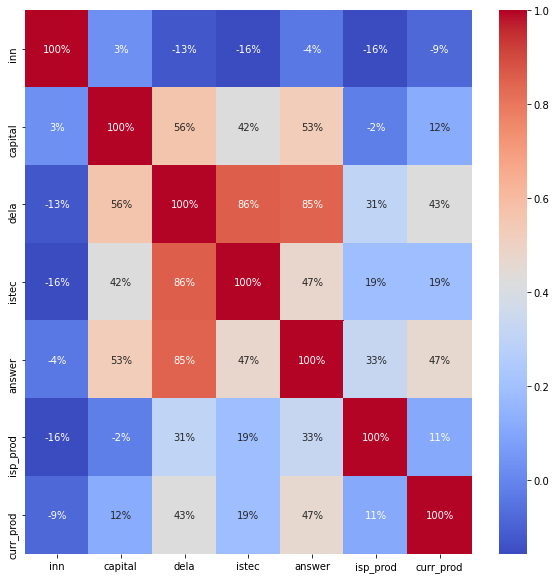

In [63]:
# Посмотрим на корреляцию признаков
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_spark_parsing.corr(), cmap="coolwarm", annot=True, ax=ax,fmt='.0%')

In [64]:
df_spark_parsing.groupby('okved').agg({'inn':'nunique'}).sort_values('inn', ascending = False).head(10)

,inn
okved,
Строительство жилых и нежилых зданий,11
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе,11
"Разведение молочного крупного рогатого скота, производство сырого молока",6
Выращивание однолетних культур,6
Управление недвижимым имуществом за вознаграждение или на договорной основе,6
unknowed,5
Аренда и управление собственным или арендованным нежилым недвижимым имуществом,5
Выращивание зерновых культур,5
Смешанное сельское хозяйство,4


<a name="3"></a><br/>
<font size="3"><b>3. Финализируем выборку.Тестим модели</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [65]:
df_final = df_spark_parsing.merge(df_bankruptcies_sample, how = 'left', on = 'inn')
df_final

,inn,link,capital,address,okved,dela,istec,answer,isp_prod,curr_prod,bancrupt_year
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c,83500,"Красноярский кр., г. Красноярск, ул. Полигонная, д. 11 д. офис 201",Строительство жилых и нежилых зданий,136,51,58,82,19,2021.0
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a,93900,"Вологодская обл., Верховажский район, д. Урусовская, ул. Покровская, д. 11",Смешанное сельское хозяйство,8,3,3,0,6,NaN
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b,18000,"Вологодская обл., Тарногский район, д. Слуда",Животноводство,33,1,27,0,8,2017.0
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f,10000,"Омская обл., г. Омск, ул. 20 Партсъезда, д. 8",Строительство жилых и нежилых зданий,113,35,53,13,53,2016.0
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f,10000,"Ростовская обл., г. Азов, проезд Литейный, д. 3 корп. - офис",Производство электрической распределительной и регулирующей аппаратуры,7,1,2,1,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...
161,7841475679,https://www.spark-interfax.ru//sankt-peterburg-tsentralny/khp-killfish-tz-inn-7841475679-ogrn-1129847005705-5dce38eb5b9944318375983229535de3,100000,"г. Санкт-Петербург, ул. Восстания, д. 30/7 литера А пом. 10Н","Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",5,2,1,0,2,NaN
162,7701568235,https://www.spark-interfax.ru//krasnodarski-krai-anapa/ooo-transsnab-inn-7701568235-ogrn-1047796886807-fd95f45a90bd43f59e6ad0fdf5b12e89,13000,"Краснодарский кр., Анапский район, г. Анапа, ул. Стахановская, д. 15 корп. 1",Разборка и снос зданий,6,3,2,0,9,2015.0
163,2721208520,https://www.spark-interfax.ru//khabarovski-krai-khabarovsk/ooo-ik-blagoveshchenskogo-ppzht-inn-2721208520-ogrn-1142721002930-0c9e101c972448bf97d4ec9265342310,69992993,"Хабаровский кр., г. Хабаровск, ул. Знаменщикова, д. 11А офис 18",Покупка и продажа собственных нежилых зданий и помещений,8,0,4,18,41,2020.0
164,6311175195,https://www.spark-interfax.ru//samarskaya-oblast-samara/ooo-pzhrt-zheleznodorozhny-inn-6311175195-ogrn-1176313086916-5b017b2da8597deee0531c9aa8c05cf6,10000,"Самарская обл., г. Самара, ул. Красноармейская, д. 153 офис 2",Управление недвижимым имуществом за вознаграждение или на договорной основе,8,8,0,0,2,NaN


In [66]:
df_final = df_final.merge(df_accounts_sample_sum, how = 'left', on = 'inn')
df_final

,inn,link,capital,address,okved,dela,istec,answer,isp_prod,curr_prod,bancrupt_year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c,83500,"Красноярский кр., г. Красноярск, ул. Полигонная, д. 11 д. офис 201",Строительство жилых и нежилых зданий,136,51,58,82,19,2021.0,0.0,672560000,892474000
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a,93900,"Вологодская обл., Верховажский район, д. Урусовская, ул. Покровская, д. 11",Смешанное сельское хозяйство,8,3,3,0,6,NaN,331829000.0,201382000,1284324000
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b,18000,"Вологодская обл., Тарногский район, д. Слуда",Животноводство,33,1,27,0,8,2017.0,12679000.0,30148000,130691000
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f,10000,"Омская обл., г. Омск, ул. 20 Партсъезда, д. 8",Строительство жилых и нежилых зданий,113,35,53,13,53,2016.0,16000000.0,3004120000,2549130000
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f,10000,"Ростовская обл., г. Азов, проезд Литейный, д. 3 корп. - офис",Производство электрической распределительной и регулирующей аппаратуры,7,1,2,1,7,NaN,1745000.0,23222000,75850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,7841475679,https://www.spark-interfax.ru//sankt-peterburg-tsentralny/khp-killfish-tz-inn-7841475679-ogrn-1129847005705-5dce38eb5b9944318375983229535de3,100000,"г. Санкт-Петербург, ул. Восстания, д. 30/7 литера А пом. 10Н","Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",5,2,1,0,2,NaN,1085000.0,358000,605000
162,7701568235,https://www.spark-interfax.ru//krasnodarski-krai-anapa/ooo-transsnab-inn-7701568235-ogrn-1047796886807-fd95f45a90bd43f59e6ad0fdf5b12e89,13000,"Краснодарский кр., Анапский район, г. Анапа, ул. Стахановская, д. 15 корп. 1",Разборка и снос зданий,6,3,2,0,9,2015.0,0.0,258527000,320154000
163,2721208520,https://www.spark-interfax.ru//khabarovski-krai-khabarovsk/ooo-ik-blagoveshchenskogo-ppzht-inn-2721208520-ogrn-1142721002930-0c9e101c972448bf97d4ec9265342310,69992993,"Хабаровский кр., г. Хабаровск, ул. Знаменщикова, д. 11А офис 18",Покупка и продажа собственных нежилых зданий и помещений,8,0,4,18,41,2020.0,100000.0,84909000,519836000
164,6311175195,https://www.spark-interfax.ru//samarskaya-oblast-samara/ooo-pzhrt-zheleznodorozhny-inn-6311175195-ogrn-1176313086916-5b017b2da8597deee0531c9aa8c05cf6,10000,"Самарская обл., г. Самара, ул. Красноармейская, д. 153 офис 2",Управление недвижимым имуществом за вознаграждение или на договорной основе,8,8,0,0,2,NaN,0.0,2086000,4264000


In [67]:
df_final.columns

Index(['inn', 'link', 'capital', 'address', 'okved', 'dela', 'istec', 'answer',
       'isp_prod', 'curr_prod', 'bancrupt_year',
       'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year'],
      dtype='object')

In [68]:
df_final.loc[df_final['bancrupt_year'].notna(), 'bancrupt_year'] = 1
df_final.loc[df_final['bancrupt_year'].isna(), 'bancrupt_year'] = 0
df_final

,inn,link,capital,address,okved,dela,istec,answer,isp_prod,curr_prod,bancrupt_year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
0,2465002653,https://www.spark-interfax.ru//krasnoyarski-krai-krasnoyarsk/ao-vodstroi-inn-2465002653-ogrn-1022402491055-161d862f911a4748b1b2d764677e968c,83500,"Красноярский кр., г. Красноярск, ул. Полигонная, д. 11 д. офис 201",Строительство жилых и нежилых зданий,136,51,58,82,19,1.0,0.0,672560000,892474000
1,3505003270,https://www.spark-interfax.ru//vologodskaya-oblast-verkhovazhski-raion/kolkhoz-n-kuloe-inn-3505003270-ogrn-1023502490153-af166567d27c4a51a368afde1c1da54a,93900,"Вологодская обл., Верховажский район, д. Урусовская, ул. Покровская, д. 11",Смешанное сельское хозяйство,8,3,3,0,6,0.0,331829000.0,201382000,1284324000
2,3517003250,https://www.spark-interfax.ru//vologodskaya-oblast-tarnogski-raion/koop-shevdenitski-inn-3517003250-ogrn-1023501489747-633a4ffef9424e07adfece45a7585e3b,18000,"Вологодская обл., Тарногский район, д. Слуда",Животноводство,33,1,27,0,8,1.0,12679000.0,30148000,130691000
3,5501078737,https://www.spark-interfax.ru//omskaya-oblast-omsk/ao-sibalpindustriya-gk-lik-inn-5501078737-ogrn-1045501012281-419a9381df314faebc9f4dad9d16e29f,10000,"Омская обл., г. Омск, ул. 20 Партсъезда, д. 8",Строительство жилых и нежилых зданий,113,35,53,13,53,1.0,16000000.0,3004120000,2549130000
4,6140019517,https://www.spark-interfax.ru//rostovskaya-oblast-azov/ao-aemz-inn-6140019517-ogrn-1026101796291-549ca21fd9e04303a500072425d98d7f,10000,"Ростовская обл., г. Азов, проезд Литейный, д. 3 корп. - офис",Производство электрической распределительной и регулирующей аппаратуры,7,1,2,1,7,0.0,1745000.0,23222000,75850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,7841475679,https://www.spark-interfax.ru//sankt-peterburg-tsentralny/khp-killfish-tz-inn-7841475679-ogrn-1129847005705-5dce38eb5b9944318375983229535de3,100000,"г. Санкт-Петербург, ул. Восстания, д. 30/7 литера А пом. 10Н","Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",5,2,1,0,2,0.0,1085000.0,358000,605000
162,7701568235,https://www.spark-interfax.ru//krasnodarski-krai-anapa/ooo-transsnab-inn-7701568235-ogrn-1047796886807-fd95f45a90bd43f59e6ad0fdf5b12e89,13000,"Краснодарский кр., Анапский район, г. Анапа, ул. Стахановская, д. 15 корп. 1",Разборка и снос зданий,6,3,2,0,9,1.0,0.0,258527000,320154000
163,2721208520,https://www.spark-interfax.ru//khabarovski-krai-khabarovsk/ooo-ik-blagoveshchenskogo-ppzht-inn-2721208520-ogrn-1142721002930-0c9e101c972448bf97d4ec9265342310,69992993,"Хабаровский кр., г. Хабаровск, ул. Знаменщикова, д. 11А офис 18",Покупка и продажа собственных нежилых зданий и помещений,8,0,4,18,41,1.0,100000.0,84909000,519836000
164,6311175195,https://www.spark-interfax.ru//samarskaya-oblast-samara/ooo-pzhrt-zheleznodorozhny-inn-6311175195-ogrn-1176313086916-5b017b2da8597deee0531c9aa8c05cf6,10000,"Самарская обл., г. Самара, ул. Красноармейская, д. 153 офис 2",Управление недвижимым имуществом за вознаграждение или на договорной основе,8,8,0,0,2,0.0,0.0,2086000,4264000


In [69]:
df_final.columns

Index(['inn', 'link', 'capital', 'address', 'okved', 'dela', 'istec', 'answer',
       'isp_prod', 'curr_prod', 'bancrupt_year',
       'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year'],
      dtype='object')

    Кикнем столбец истец, т.к. он коррелирует с ответчиком.

In [70]:
df_final = df_final[['okved', 'dela', 'answer', 'isp_prod', 'curr_prod', 'bancrupt_year',
       'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year']]
df_final = df_final.reset_index()

In [71]:
s = pd.Series(df_final.okved)
df_okved = pd.get_dummies(s)
df_okved = df_okved.reset_index()

In [72]:
df_final = df_final.merge(df_okved, on = 'index', how = 'left')
df_final

,index,okved,dela,answer,isp_prod,curr_prod,bancrupt_year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,...,Торговля розничная книгами в специализированных магазинах,Торговля розничная лекарственными средствами в специализированных магазинах (аптеках),"Торговля розничная незамороженными продуктами, включая напитки и табачные изделия, в неспециализированных магазинах",Торговля розничная одеждой в специализированных магазинах,"Торговля розничная преимущественно пищевыми продуктами, включая напитки, и табачными изделиями в неспециализированных магазинах",Торговля розничная прочая в неспециализированных магазинах,Торговля розничная текстильными изделиями в специализированных магазинах,Управление недвижимым имуществом за вознаграждение или на договорной основе,Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе,Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе
0,0,Строительство жилых и нежилых зданий,136,58,82,19,1.0,0.0,672560000,892474000,...,0,0,0,0,0,0,0,0,0,0
1,1,Смешанное сельское хозяйство,8,3,0,6,0.0,331829000.0,201382000,1284324000,...,0,0,0,0,0,0,0,0,0,0
2,2,Животноводство,33,27,0,8,1.0,12679000.0,30148000,130691000,...,0,0,0,0,0,0,0,0,0,0
3,3,Строительство жилых и нежилых зданий,113,53,13,53,1.0,16000000.0,3004120000,2549130000,...,0,0,0,0,0,0,0,0,0,0
4,4,Производство электрической распределительной и регулирующей аппаратуры,7,2,1,7,0.0,1745000.0,23222000,75850000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,161,"Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",5,1,0,2,0.0,1085000.0,358000,605000,...,0,0,0,0,0,0,0,0,0,0
162,162,Разборка и снос зданий,6,2,0,9,1.0,0.0,258527000,320154000,...,0,0,0,0,0,0,0,0,0,0
163,163,Покупка и продажа собственных нежилых зданий и помещений,8,4,18,41,1.0,100000.0,84909000,519836000,...,0,0,0,0,0,0,0,0,0,0
164,164,Управление недвижимым имуществом за вознаграждение или на договорной основе,8,0,0,2,0.0,0.0,2086000,4264000,...,0,0,0,0,0,0,0,1,0,0


In [73]:
df_features = df_final.drop(columns=['index', 'okved','bancrupt_year'])
df_features

,dela,answer,isp_prod,curr_prod,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,unknowed,Аренда и управление собственным или арендованным недвижимым имуществом,Аренда и управление собственным или арендованным нежилым недвижимым имуществом,...,Торговля розничная книгами в специализированных магазинах,Торговля розничная лекарственными средствами в специализированных магазинах (аптеках),"Торговля розничная незамороженными продуктами, включая напитки и табачные изделия, в неспециализированных магазинах",Торговля розничная одеждой в специализированных магазинах,"Торговля розничная преимущественно пищевыми продуктами, включая напитки, и табачными изделиями в неспециализированных магазинах",Торговля розничная прочая в неспециализированных магазинах,Торговля розничная текстильными изделиями в специализированных магазинах,Управление недвижимым имуществом за вознаграждение или на договорной основе,Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе,Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе
0,136,58,82,19,0.0,672560000,892474000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,3,0,6,331829000.0,201382000,1284324000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,27,0,8,12679000.0,30148000,130691000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,113,53,13,53,16000000.0,3004120000,2549130000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,2,1,7,1745000.0,23222000,75850000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,5,1,0,2,1085000.0,358000,605000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,6,2,0,9,0.0,258527000,320154000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,8,4,18,41,100000.0,84909000,519836000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,8,0,0,2,0.0,2086000,4264000,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [74]:
df_target = df_final['bancrupt_year'].astype(int)
df_target

0      1
1      0
2      1
3      1
4      0
      ..
161    0
162    1
163    1
164    0
165    1
Name: bancrupt_year, Length: 166, dtype: int64

In [75]:
# Сделаем функцию визуального анализа
def make_analyz(df_name, list_of_features):
    for feature in list_of_features:
        display('Распределение по признаку:',feature, df_name[feature].describe())
        
        fig = plt.figure(figsize=(15,3))
        fig.suptitle('Графики по начальным данным', fontsize='x-large')
        plt.subplot(1, 3, 1)
        sns.distplot(df_name[feature], label = feature)
        
        plt.subplot(1, 3, 2)
        sns.boxplot(df_name[feature], palette='rainbow')
        plt.subplot(1, 3, 3)
        sns.scatterplot(x = df_name.index, y = df_name[feature])
                
        # Cрежем выбросы, по 1 и 99 перцентелю
        percantiles = np.percentile(df_name[feature], [1, 99])
        print('1й перцентель', percantiles[0])
        print('99й перцентель', percantiles[1])
        df_name = df_name[df_name[feature]>percantiles[0]].reset_index(drop=True)
        df_name = df_name[df_name[feature]<percantiles[1]].reset_index(drop=True)
        fig = plt.figure(figsize=(15,3))
        fig.suptitle('Графики со срезанными данными по 1 и 99 перцентелю', fontsize='x-large')
        plt.subplot(1, 3, 1)
        sns.distplot(df_name[feature], label = feature)
        
        plt.subplot(1, 3, 2)
        sns.boxplot(df_name[feature], palette='rainbow')
        
        plt.subplot(1, 3, 3)
        sns.scatterplot(x = df_name.index, y = df_name[feature])
        plt.show()

In [76]:
df_final.columns

Index(['index', 'okved', 'dela', 'answer', 'isp_prod', 'curr_prod',
       'bancrupt_year', 'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year',
       'unknowed',
       'Аренда и управление собственным или арендованным недвижимым имуществом',
       'Аренда и управление собственным или арендованным нежилым недвижимым имуществом',
       'Выращивание зерновых (кроме риса), зернобобовых культур и семян масличных культур',
       'Выращивание зерновых культур', 'Выращивание однолетних культур',
       'Выращивание столовых корнеплодных и клубнеплодных культур с высоким содержанием крахмала или инулина',
       'Деятельность агентств недвижимости за вознаграждение или на договорной основе',
       'Деятельность в области гидрометеорологии и смежных с ней областях, мониторинга состояния окружающей среды, ее загрязнения',
       'Деятельность в области права и бухгалтерского учета',
       'Деятельность в области радиовещания',
   

'Распределение по признаку:'

'answer'

count    166.000000
mean     20.421687 
std      37.959666 
min      0.000000  
25%      2.000000  
50%      7.000000  
75%      24.000000 
max      302.000000
Name: answer, dtype: float64

1й перцентель 0.0
99й перцентель 188.8999999999997


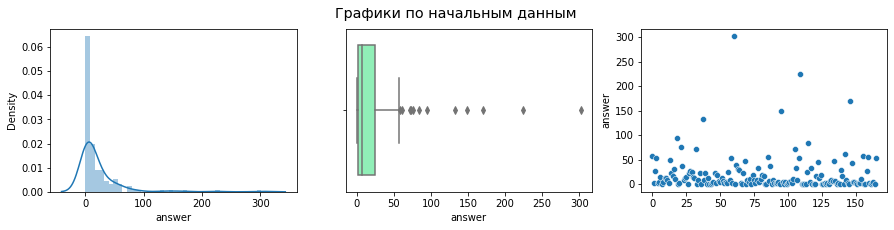

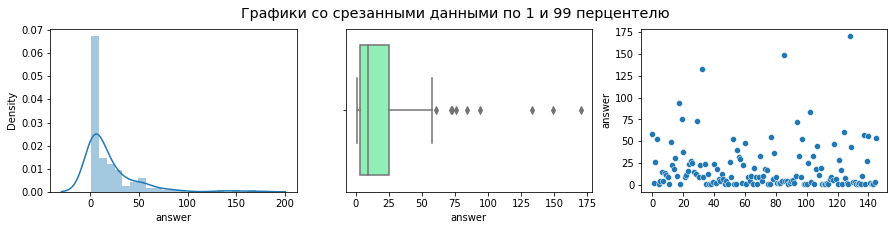

'Распределение по признаку:'

'isp_prod'

count    146.000000
mean     3.232877  
std      10.158089 
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      82.000000 
Name: isp_prod, dtype: float64

1й перцентель 0.0
99й перцентель 54.050000000000125


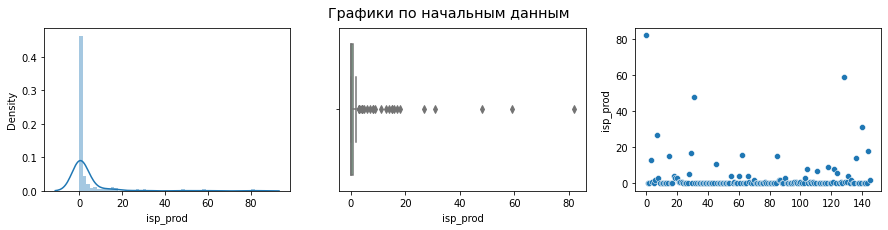

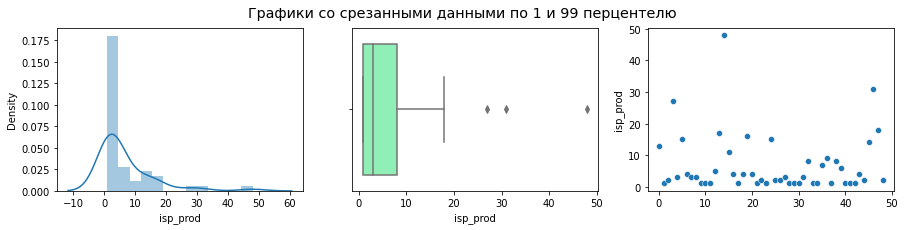

'Распределение по признаку:'

'curr_prod'

count    49.000000  
mean     103.081633 
std      292.040939 
min      0.000000   
25%      18.000000  
50%      43.000000  
75%      85.000000  
max      2055.000000
Name: curr_prod, dtype: float64

1й перцентель 0.48
99й перцентель 1199.6399999999928


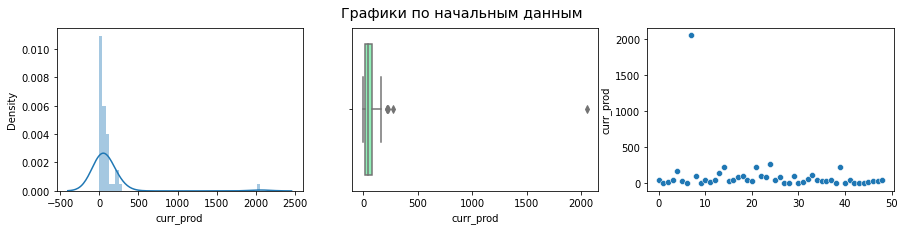

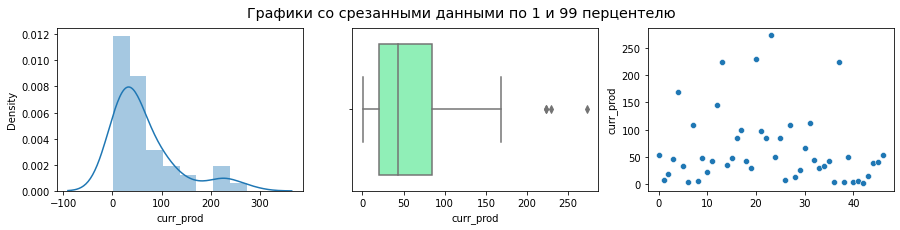

In [77]:
make_analyz(df_final, [ 'answer', 'isp_prod', 'curr_prod'])

'Распределение по признаку:'

'long_term_liabilities_fiscal_year'

count    1.660000e+02
mean     6.545097e+08
std      5.816424e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.600150e+07
max      7.372531e+10
Name: long_term_liabilities_fiscal_year, dtype: float64

1й перцентель 0.0
99й перцентель 8388378149.999981


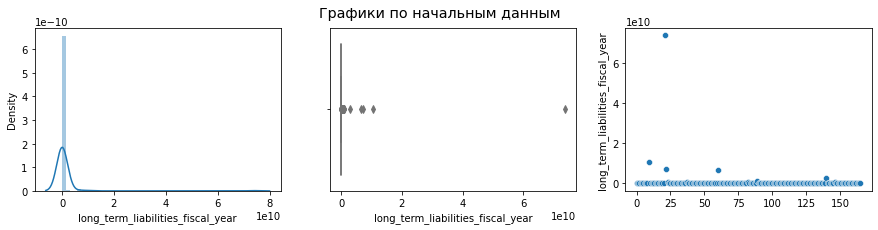

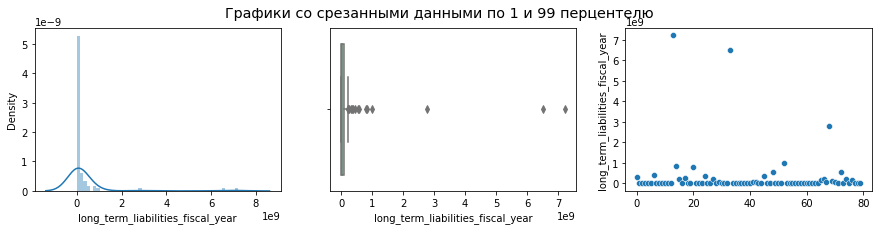

'Распределение по признаку:'

'short_term_liabilities_fiscal_year'

count    8.000000e+01
mean     7.134169e+08
std      1.355092e+09
min      3.580000e+05
25%      2.695100e+07
50%      9.815850e+07
75%      7.473842e+08
max      7.090456e+09
Name: short_term_liabilities_fiscal_year, dtype: float64

1й перцентель 872290.0
99й перцентель 5853402109.99999


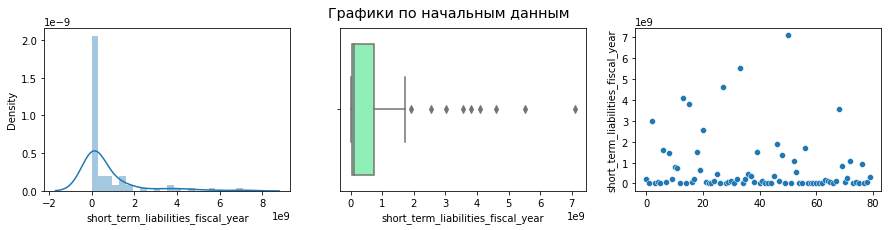

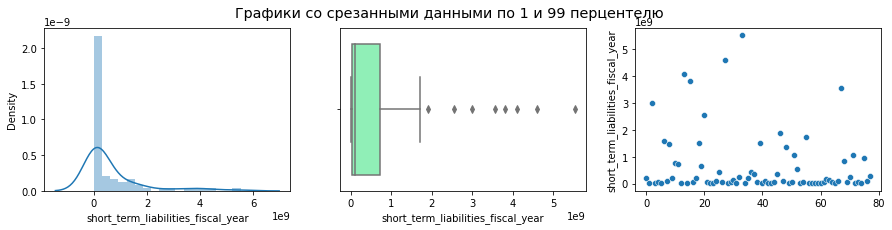

'Распределение по признаку:'

'balance_assets_fiscal_year'

count    7.800000e+01
mean     1.165221e+09
std      2.351929e+09
min      4.210000e+06
25%      7.361050e+07
50%      2.350030e+08
75%      1.285321e+09
max      1.528159e+10
Name: balance_assets_fiscal_year, dtype: float64

1й перцентель 8856180.0
99й перцентель 11067992690.000023


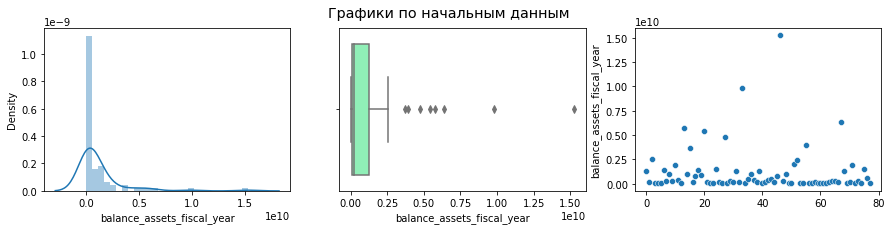

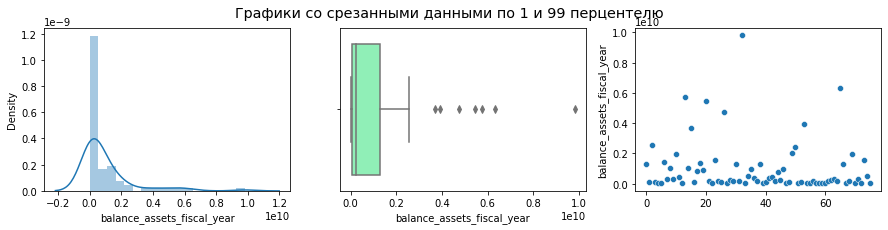

In [78]:
make_analyz(df_final, [ 'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year'])

In [79]:
# бьём даные на выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    df_features, df_target, test_size = 0.20, random_state = 666)

In [80]:
for name in [features_train, target_train, features_valid, target_valid]:
    print('Размерность:',name.shape)

Размерность: (132, 97)
Размерность: (132,)
Размерность: (34, 97)
Размерность: (34,)


In [81]:
target_valid.value_counts()

1    22
0    12
Name: bancrupt_year, dtype: int64

In [82]:
df_final['bancrupt_year'].value_counts()

1.0    106
0.0    60 
Name: bancrupt_year, dtype: int64

    Дисбаланс по таргету.

In [83]:
# порог адекватности
1 - 106/166

0.3614457831325302

    Алгоритмы машинного обучения, как правило, работают лучше или сходятся быстрее, когда различные функции (переменные) имеют меньший масштаб. Поэтому перед обучением на них моделей машинного обучения данные обычно нормализуются.
    MinMaxScaler() популярный выбор для нормализации наборов данных.

In [84]:
# маштабирование признаков
scaler = MinMaxScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

# масштабируем количественные признаки в тестовой выборке
features_valid = scaler.transform(features_valid)


In [85]:
def parametrs_finder(model_name):
    # разбиение на подвыборки для кросс-валидации
    kf = KFold(n_splits = 4, shuffle = True, random_state = 666)
        
    parameters = {'learning_rate': [1, 0.1, 0.001, 0.001],
                    'n_estimators': [100, 250, 500, 1000], 
                    'max_depth': [100, 250, 500, 1000],
                  'num_leaves': [100, 250, 500, 1000]
                 }
    if model_name == RandomForestClassifier:
        del parameters['learning_rate']
        del parameters['num_leaves']
        
    if model_name == DecisionTreeClassifier:
        del parameters['learning_rate']
        del parameters['num_leaves']
        del parameters['n_estimators']
        
    gs = GridSearchCV(model_name(random_state = 666), 
                      parameters,
                      cv = kf,
                      scoring = 'f1',
                      verbose = True,
                      n_jobs = -1)

    # обучение
    gs.fit(features_train, target_train)
    # лучшие параметры
    print(gs.best_params_)

In [86]:
# создадим таблу для результатов
TestModels = DataFrame()

In [87]:
def fit_predict(model_with_best_param):
    start = time.time()
    model = model_with_best_param
    
    # обучение
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    end = time.time()
    feature_importances = pd.Series(model.feature_importances_, index = df_features.columns)
    feature_importances.nlargest(10).to_dict()
    
    # пишем в словарь результаты
    tmp = {}
    tmp['name_of_model'] = str(model_with_best_param)[:str(model_with_best_param).index('(')]
    tmp['fiting time'] = (end-start)
    tmp['f1_score'] = f1_score(target_valid, predicted)
    tmp['accuracy_score'] = accuracy_score(target_valid, predicted)
    tmp['precision_score'] = precision_score(target_valid, predicted)
    tmp['recall_score'] = recall_score(target_valid, predicted)
    tmp['feature_importances'] = feature_importances.nlargest(10).to_dict()
    return tmp

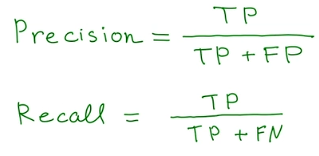

FP - ложные срабатывания
FN - не нашли банкрота

In [88]:
%%time
parametrs_finder(LGBMClassifier)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   14.2s


{'learning_rate': 0.001, 'max_depth': 100, 'n_estimators': 1000, 'num_leaves': 100}
CPU times: user 1.5 s, sys: 177 ms, total: 1.68 s
Wall time: 24 s


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:   23.8s finished


In [89]:
TestModels = TestModels.append([fit_predict(LGBMClassifier(random_state = 666, 
                                                          learning_rate = 0.001,
                                                          max_depth = 100,
                                                          n_estimators = 1000,
                                                          num_leaves = 100, 
                                                          n_jobs = -1))])

In [90]:
TestModels

,name_of_model,fiting time,f1_score,accuracy_score,precision_score,recall_score,feature_importances
0,LGBMClassifier,0.141792,0.863636,0.823529,0.863636,0.863636,"{'curr_prod': 1304, 'answer': 1082, 'short_term_liabilities_fiscal_year': 612, 'dela': 610, 'long_term_liabilities_fiscal_year': 442, 'balance_assets_fiscal_year': 185, 'isp_prod': 40, 'unknowed': 0, 'Аренда и управление собственным или арендованным недвижимым имуществом': 0, 'Аренда и управление собственным или арендованным нежилым недвижимым имуществом': 0}"


In [91]:
%%time
parametrs_finder(DecisionTreeClassifier)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
{'max_depth': 100}
CPU times: user 22 ms, sys: 12 ms, total: 34.1 ms
Wall time: 104 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished


In [92]:
TestModels = TestModels.append([fit_predict(DecisionTreeClassifier(random_state = 666, 
                                                          max_depth = 100))])

In [93]:
TestModels

,name_of_model,fiting time,f1_score,accuracy_score,precision_score,recall_score,feature_importances
0,LGBMClassifier,0.141792,0.863636,0.823529,0.863636,0.863636,"{'curr_prod': 1304, 'answer': 1082, 'short_term_liabilities_fiscal_year': 612, 'dela': 610, 'long_term_liabilities_fiscal_year': 442, 'balance_assets_fiscal_year': 185, 'isp_prod': 40, 'unknowed': 0, 'Аренда и управление собственным или арендованным недвижимым имуществом': 0, 'Аренда и управление собственным или арендованным нежилым недвижимым имуществом': 0}"
0,DecisionTreeClassifier,0.003255,0.850000,0.823529,0.944444,0.772727,"{'curr_prod': 0.4424239376601705, 'balance_assets_fiscal_year': 0.13109751146835538, 'dela': 0.06547619047619048, 'answer': 0.05569429611982804, 'short_term_liabilities_fiscal_year': 0.04583333333333333, 'Деятельность вспомогательная в области производства сельскохозяйственных культур и послеуборочной обработки сельхозпродукции': 0.03127961383558408, 'Строительство жилых и нежилых зданий': 0.030935551303854874, 'Деятельность по складированию и хранению': 0.030359625193360877, 'unknowed': 0.029479636057321533, 'Производство электроэнергии тепловыми электростанциями, в том числе деятельность по обеспечению работоспособности электростанций': 0.028171268507402952}"


In [94]:
%%time
parametrs_finder(RandomForestClassifier)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   22.8s finished


{'max_depth': 100, 'n_estimators': 250}
CPU times: user 462 ms, sys: 16.3 ms, total: 479 ms
Wall time: 23.2 s


In [95]:
TestModels = TestModels.append([fit_predict(RandomForestClassifier(random_state = 666, 
                                                          max_depth = 100,
                                                          n_estimators = 100))])                                                          

In [96]:
TestModels = TestModels.sort_values('f1_score',  ascending = False).reset_index(drop = True)
TestModels

,name_of_model,fiting time,f1_score,accuracy_score,precision_score,recall_score,feature_importances
0,RandomForestClassifier,0.155834,0.904762,0.882353,0.950000,0.863636,"{'curr_prod': 0.21616625632402203, 'answer': 0.13703704687160995, 'dela': 0.11694574753385306, 'balance_assets_fiscal_year': 0.11565644601968406, 'short_term_liabilities_fiscal_year': 0.09950617895594417, 'long_term_liabilities_fiscal_year': 0.036698743378567794, 'isp_prod': 0.027597912867495383, 'Аренда и управление собственным или арендованным недвижимым имуществом': 0.01690099573766434, 'Аренда и управление собственным или арендованным нежилым недвижимым имуществом': 0.016472004255518893, 'Деятельность по складированию и хранению': 0.016073613744643694}"
1,LGBMClassifier,0.141792,0.863636,0.823529,0.863636,0.863636,"{'curr_prod': 1304, 'answer': 1082, 'short_term_liabilities_fiscal_year': 612, 'dela': 610, 'long_term_liabilities_fiscal_year': 442, 'balance_assets_fiscal_year': 185, 'isp_prod': 40, 'unknowed': 0, 'Аренда и управление собственным или арендованным недвижимым имуществом': 0, 'Аренда и управление собственным или арендованным нежилым недвижимым имуществом': 0}"
2,DecisionTreeClassifier,0.003255,0.850000,0.823529,0.944444,0.772727,"{'curr_prod': 0.4424239376601705, 'balance_assets_fiscal_year': 0.13109751146835538, 'dela': 0.06547619047619048, 'answer': 0.05569429611982804, 'short_term_liabilities_fiscal_year': 0.04583333333333333, 'Деятельность вспомогательная в области производства сельскохозяйственных культур и послеуборочной обработки сельхозпродукции': 0.03127961383558408, 'Строительство жилых и нежилых зданий': 0.030935551303854874, 'Деятельность по складированию и хранению': 0.030359625193360877, 'unknowed': 0.029479636057321533, 'Производство электроэнергии тепловыми электростанциями, в том числе деятельность по обеспечению работоспособности электростанций': 0.028171268507402952}"


<a name="4"></a><br/>
<font size="3"><b>4. Выводы</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

<br/>
<div class="col-md-3">
  <ul class="nav nav-pills nav-stacked"> 
    <li class="active"><a class="nav-link" id="home-tab" data-toggle="pill" href="#output2" role="tab" aria-controls="output2" aria-selected="false">Анализ данных</a></li>
    <li><a class="nav-link" id="profile-tab" data-toggle="pill" href="#output3" role="tab" aria-controls="output3" aria-selected="false">Важные компоненты</a></li>
          <li><a class="nav-link" id="profile-tab" data-toggle="pill" href="#output4" role="tab" aria-controls="output4" aria-selected="false">Выбор признаков для построения моделей. Выбранные модели.</a></li>
      <li><a class="nav-link" id="contact-tab" data-toggle="pill" href="#output5" role="tab" aria-controls="output5" aria-selected="false">Анализ моделей. Выводы</a></li>
   
</ul>
</div>

<div class="tab-content">
<div id="output2" class="tab-pane fade in active">
    <h3 style="margin-left:270px">Анализ данных</h3>
    <p style="margin-left:270px">
        
Данные были проанализированы, оставлены только те фичи, по которым тренировали модель.
Были спарсены данные, заявлены как новые фичи.
</p>
  </div>

  <div id="output3" class="tab-pane fade">
      <h3 style="margin-left:270px">Важные компоненты</h3>
      <p>
    <p style="margin-left:270px"> 
  Установлено:<br> 
    - ТОП - популярных фич:
        - Количество дел,отчветчиком/истцом 
        - баланс задолжностей, 
        - тип деятельности.
         <br>
            </p>
  </div>

  <div id="output4" class="tab-pane fade">
      <h3 style="margin-left:270px">Выбор признаком для построения моделей. Выбранные модели.</h3>
      <p>
    <p style="margin-left:270px">
        Дабы исключить мультикорреляции, кикнули коррелирующие признаки, а именно:
        количество дел в качестве исца
 
        Использованы модели:
        LGBMClassifier, RandomForestClassifier ,DecisionClassifier 
        Для каждой модели были подобраны параметры с помощью GridSearchCV.
        А также найдены важные фичи для предсказания.        
        
    
  </p>
  </div>
    
                    
<div id="output" class="tab-pane fade">
      <h3 style="margin-left:270px">Рекомендации</h3>
      <p>
        <p style="margin-left:270px">  
           

</p>
            </div>
            <div id="output5" class="tab-pane fade">
      <h3 style="margin-left:270px">Анализ моделей. Выводы</h3> 
      <p>
        <p style="margin-left:270px">  
             Видим, что победил RandomForestClassifier с лучшим показателем по целевой метрике 0.9, уступив лишь по скорости работы DecisionTreeRegressor
    
        
</p>
</div>
</div>
        